In [1]:
import os
import csv

In [2]:
# Lista de carpetas y etiquetas correspondientes
carpetas = [
    (r"C:\Users\Usuario\Desktop\mi_proyecto\1bloqueo", "bloqueo"),
    (r"C:\Users\Usuario\Desktop\mi_proyecto\1crochet", "crochet"),
    (r"C:\Users\Usuario\Desktop\mi_proyecto\1cross", "cross"),
    (r"C:\Users\Usuario\Desktop\mi_proyecto\1esquiva", "esquiva"),
    (r"C:\Users\Usuario\Desktop\mi_proyecto\1hook", "hook"),
    (r"C:\Users\Usuario\Desktop\mi_proyecto\1jab", "jab"),
    (r"C:\Users\Usuario\Desktop\mi_proyecto\1overhand", "overhand"),
    (r"C:\Users\Usuario\Desktop\mi_proyecto\1uppercut", "uppercut"),
    (r"C:\Users\Usuario\Desktop\mi_proyecto\1sin_accion","sin_accion")
]

# Nombre del archivo CSV de salida
csv_output = "archivos_carpetas.csv"

# Crear y abrir el archivo CSV para escritura
with open(csv_output, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Escribir la cabecera del CSV
    writer.writerow(["nombre_archivo", "etiqueta"])
    
    # Recorrer cada carpeta y su etiqueta correspondiente
    for carpeta, etiqueta in carpetas:
        # Recorrer cada archivo en la carpeta
        for archivo in os.listdir(carpeta):
            # Crear la ruta completa del archivo
            archivo_path = os.path.join(carpeta, archivo)
            # Verificar si es un archivo (y no una subcarpeta)
            if os.path.isfile(archivo_path):
                # Escribir la información en el CSV
                writer.writerow([archivo, etiqueta])

print(f"Archivo CSV '{csv_output}' creado exitosamente.")

Archivo CSV 'archivos_carpetas.csv' creado exitosamente.


In [3]:
#preprocesamiento de las imágenes, que incluye la normalización y el redimensionamiento, 
#y luego la división del dataset en conjuntos de entrenamiento, validación y prueba

###  Importar Librerías y Configuración

In [4]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
image_size = (64, 64)  # Tamaño al que redimensionar las imágenes
csv_path = r"C:\Users\Usuario\Desktop\mi_proyecto\archivos_carpetas.csv"
image_dir = r"C:\Users\Usuario\Desktop\mi_proyecto\imagenes"
output_dir = r"C:\Users\Usuario\Desktop\mi_proyecto\imagenes_procesadas"

# Leer el archivo CSV
df = pd.read_csv(csv_path)

### Cargar y Preprocesar Imágenes

In [5]:
# Función para cargar y preprocesar imágenes
def load_and_preprocess_image(filepath):
    if not os.path.exists(filepath):
        print(f"Archivo no encontrado: {filepath}")
        return None
    image = cv2.imread(filepath)
    if image is None:
        print(f"Error al cargar la imagen: {filepath}")
        return None
    image = cv2.resize(image, image_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalizar la imagen
    return image

# Cargar y preprocesar las imágenes
def load_images(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        filepath = os.path.join(image_dir, row['nombre_archivo'])
        image = load_and_preprocess_image(filepath)
        if image is not None:
            images.append(image)
            labels.append(row['etiqueta'])
    return np.array(images), np.array(labels)

# Convertir etiquetas a números
def convert_labels(labels):
    label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
    return np.array([label_mapping[label] for label in labels])

# Cargar y dividir datos
images, labels = load_images(df)
labels = convert_labels(labels)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Guardar los conjuntos de datos
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

np.save(os.path.join(output_dir, 'X_train.npy'), X_train)
np.save(os.path.join(output_dir, 'y_train.npy'), y_train)
np.save(os.path.join(output_dir, 'X_val.npy'), X_val)
np.save(os.path.join(output_dir, 'y_val.npy'), y_val)
np.save(os.path.join(output_dir, 'X_test.npy'), X_test)
np.save(os.path.join(output_dir, 'y_test.npy'), y_test)

print("Preprocesamiento completado y datos guardados.")

Preprocesamiento completado y datos guardados.


### Crear Secuencias de Datos

In [6]:
# Función para crear secuencias
def create_sequences(data, labels, seq_length):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
        sequence_labels.append(labels[i + seq_length - 1])
    return np.array(sequences), np.array(sequence_labels)

# Cargar los conjuntos de datos preprocesados
X_train = np.load(os.path.join(output_dir, 'X_train.npy'))
y_train = np.load(os.path.join(output_dir, 'y_train.npy'))
X_val = np.load(os.path.join(output_dir, 'X_val.npy'))
y_val = np.load(os.path.join(output_dir, 'y_val.npy'))
X_test = np.load(os.path.join(output_dir, 'X_test.npy'))
y_test = np.load(os.path.join(output_dir, 'y_test.npy'))

# Crear secuencias para los datos de entrenamiento, validación y prueba
seq_length = 10
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")

X_train_seq shape: (9938, 10, 64, 64, 3)
y_train_seq shape: (9938,)
X_val_seq shape: (2123, 10, 64, 64, 3)
y_val_seq shape: (2123,)
X_test_seq shape: (2123, 10, 64, 64, 3)
y_test_seq shape: (2123,)


### Definir y Compilar el Modelo

In [7]:
# Definir la arquitectura del modelo CNN + LSTM
model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(seq_length, *image_size, 3)),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(128, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    LSTM(64, return_sequences=False),  # LSTM con return_sequences=False para salida plana antes de Dense
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 10, 62, 62, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 31, 31, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 10, 29, 29, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 10, 14, 14, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 10, 12, 12, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 10, 6, 6, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 10, 4608)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │       1,196,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,327,433 (5.06 MB)

 Trainable params: 1,327,433 (5.06 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenar el Modelo

In [8]:
# Definir los callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo usando generadores de datos
def data_generator(X, y, batch_size):
    while True:
        idx = np.random.randint(0, X.shape[0], batch_size)
        yield X[idx], y[idx]

batch_size = 32
train_gen = data_generator(X_train_seq, y_train_seq, batch_size)
val_gen = data_generator(X_val_seq, y_val_seq, batch_size)

steps_per_epoch = X_train_seq.shape[0] // batch_size
validation_steps = X_val_seq.shape[0] // batch_size

# Entrenar el modelo
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.1554 - loss: 2.1303 - val_accuracy: 0.2945 - val_loss: 1.9380
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.3627 - loss: 1.7738 - val_accuracy: 0.5412 - val_loss: 1.3585
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.6835 - loss: 0.9739 - val_accuracy: 0.8163 - val_loss: 0.6033
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.8792 - loss: 0.3946 - val_accuracy: 0.8887 - val_loss: 0.3533
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.9421 - loss: 0.1974 - val_accuracy: 0.9295 - val_loss: 0.2399
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.9696 - loss: 0.1065 - val_accuracy: 0.9200 - val_loss: 0.2463
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.9730 - loss: 0.0933 - val_accuracy: 0.9437 - val_loss: 0.2100
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.9855 - loss: 0.0513 - val_accu

### Evaluar el Modelo y Guardar los Resultados

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       276
           1       0.95      0.97      0.96       327
           2       0.98      0.96      0.97       232
           3       0.97      0.96      0.97       309
           4       0.99      0.93      0.96       189
           5       0.99      0.96      0.97       246
           6       0.97      0.92      0.95        39
           7       0.96      0.98      0.97       195
           8       0.94      0.99      0.97       310

    accuracy                           0.97      2123
   macro avg       0.97      0.96      0.96      2123
weighted avg       0.97      0.97      0.97      2123



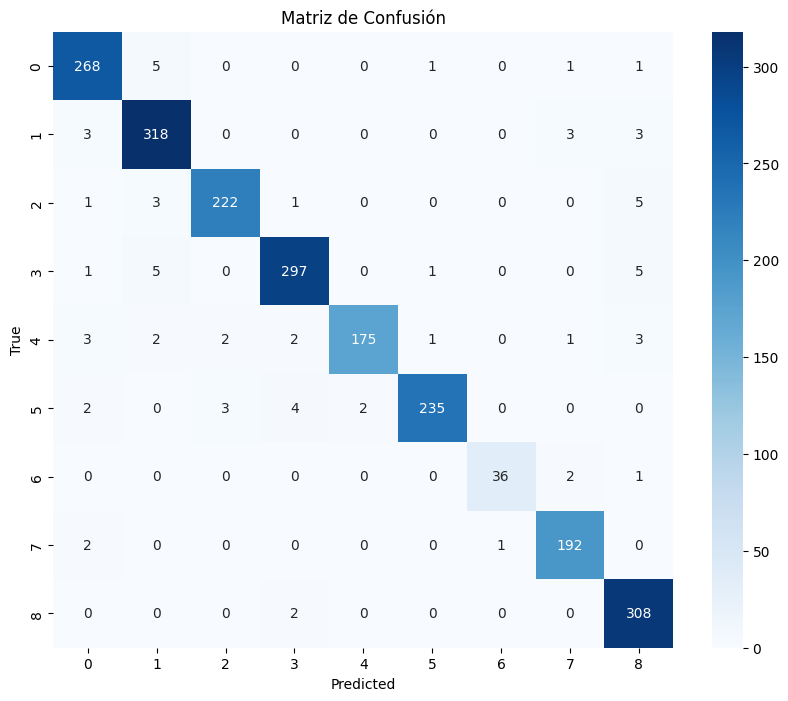

Modelo guardado correctamente en formato HDF5.


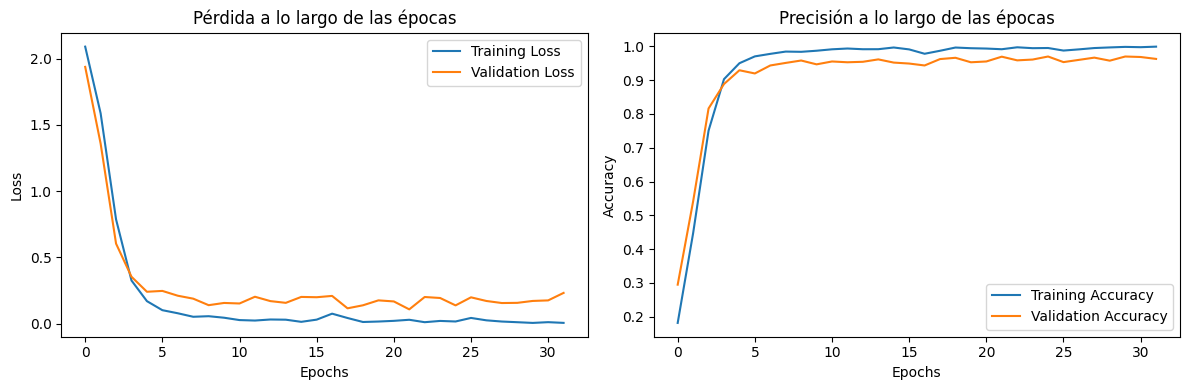

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones
y_pred = model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)

# Reporte de clasificación
report = classification_report(y_test_seq, y_pred_classes, target_names=np.unique(y_train).astype(str))
print("Reporte de Clasificación:")
print(report)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test_seq, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_train).astype(str), 
            yticklabels=np.unique(y_train).astype(str))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

# Guardar el modelo entrenado en formato HDF5
model.save('path_to_saved_model.h5')

print("Modelo guardado correctamente en formato HDF5.")

# Graficar las métricas de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Pérdida a lo largo de las épocas')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Precisión a lo largo de las épocas')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
import os
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [5]:
# Configuración
image_size = (224, 224)  # Tamaño al que redimensionar las imágenes
csv_path = r"C:\Users\Usuario\Desktop\mi_proyecto\archivos_carpetas.csv"
image_dir = r"C:\Users\Usuario\Desktop\mi_proyecto\imagenes"
output_dir = r"C:\Users\Usuario\Desktop\mi_proyecto\imagenes_procesadas"

# Leer el archivo CSV
df = pd.read_csv(csv_path)

# Función para cargar y preprocesar imágenes
def load_and_preprocess_image(filepath):
    if not os.path.exists(filepath):
        print(f"Archivo no encontrado: {filepath}")
        return None
    image = cv2.imread(filepath)
    if image is None:
        print(f"Error al cargar la imagen: {filepath}")
        return None
    image = cv2.resize(image, image_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalizar la imagen
    return image

# Cargar y preprocesar las imágenes
images = []
labels = []

for index, row in df.iterrows():
    filepath = os.path.join(image_dir, row['nombre_archivo'])
    image = load_and_preprocess_image(filepath)
    if image is not None:
        images.append(image)
        labels.append(row['etiqueta'])

# Convertir a arrays de numpy
images = np.array(images)
labels = np.array(labels)

# Convertir etiquetas a números
label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
labels = np.array([label_mapping[label] for label in labels])

# Dividir el dataset en entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Guardar los conjuntos de datos
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

np.save(os.path.join(output_dir, 'X_train.npy'), X_train)
np.save(os.path.join(output_dir, 'y_train.npy'), y_train)
np.save(os.path.join(output_dir, 'X_val.npy'), X_val)
np.save(os.path.join(output_dir, 'y_val.npy'), y_val)
np.save(os.path.join(output_dir, 'X_test.npy'), X_test)
np.save(os.path.join(output_dir, 'y_test.npy'), y_test)

print("Preprocesamiento completado y datos guardados.")

Preprocesamiento completado y datos guardados.


X_train shape: (9947, 128, 128, 3)
y_train shape: (9947,)
X_val shape: (2132, 128, 128, 3)
y_val shape: (2132,)
X_test shape: (2132, 128, 128, 3)
y_test shape: (2132,)
Epoch 1/50


C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


311/311 ━━━━━━━━━━━━━━━━━━━━ 1681s 5s/step - accuracy: 0.2286 - loss: 1.9955 - val_accuracy: 0.5765 - val_loss: 1.2398
Epoch 2/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 1705s 5s/step - accuracy: 0.7140 - loss: 0.8838 - val_accuracy: 0.8761 - val_loss: 0.4082
Epoch 3/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 1695s 5s/step - accuracy: 0.9368 - loss: 0.2307 - val_accuracy: 0.9501 - val_loss: 0.1737
Epoch 4/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 1724s 6s/step - accuracy: 0.9820 - loss: 0.0728 - val_accuracy: 0.9713 - val_loss: 0.1044
Epoch 5/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 1710s 5s/step - accuracy: 0.9897 - loss: 0.0401 - val_accuracy: 0.9661 - val_loss: 0.1228
Epoch 6/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 1769s 6s/step - accuracy: 0.9907 - loss: 0.0290 - val_accuracy: 0.9741 - val_loss: 0.1051
Epoch 7/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 1687s 5s/step - accuracy: 0.9934 - loss: 0.0262 - val_accuracy: 0.9675 - val_loss: 0.1281
Epoch 8/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 1689s 5s/step - accuracy: 0.9947 - loss: 0.0214 - val_accurac

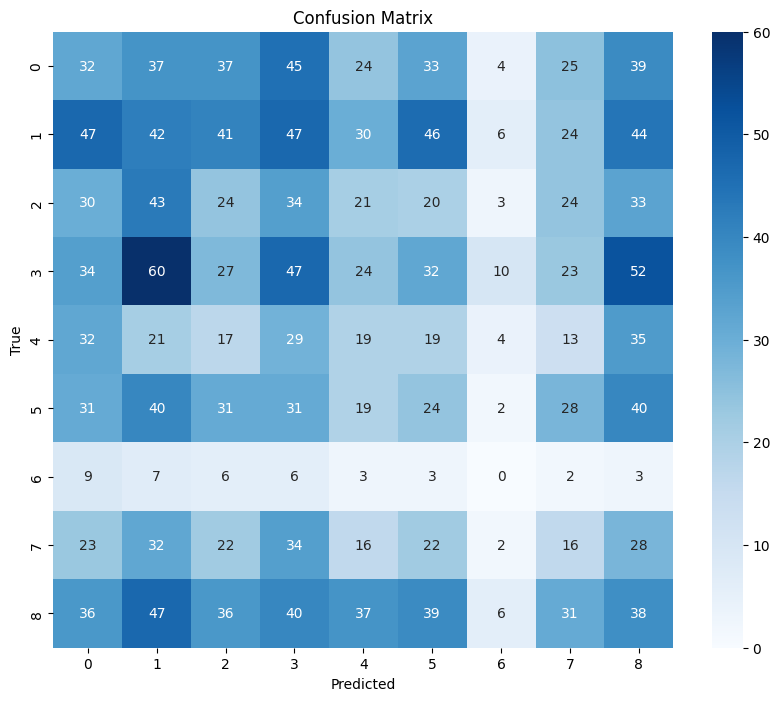

Entrenamiento completado y modelo guardado.


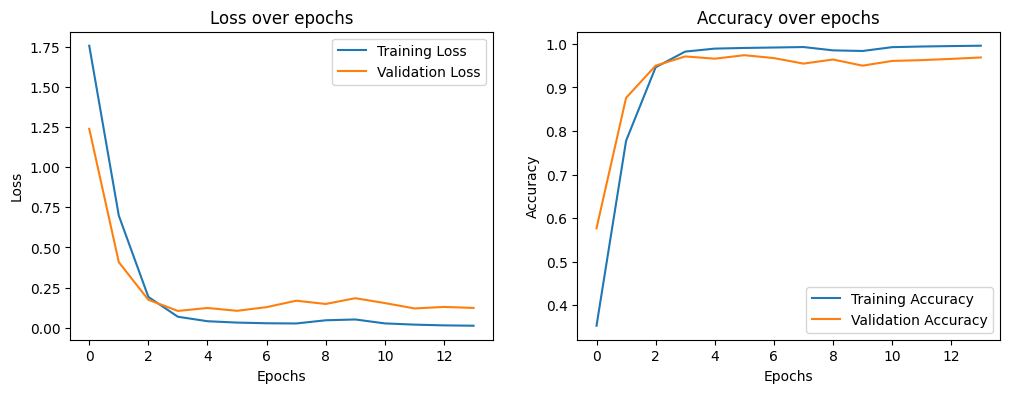

In [9]:
import numpy as np
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Reshape, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import Sequence

# Función para cargar datos
def load_data(output_dir, file_name):
    file_path = os.path.join(output_dir, file_name)
    data = np.load(file_path)
    return data

# Redimensionar imágenes
def resize_images(data, new_size):
    resized_data = np.zeros((data.shape[0], new_size, new_size, data.shape[3]), dtype=np.float32)
    for i in range(data.shape[0]):
        resized_data[i] = cv2.resize(data[i], (new_size, new_size))
    return resized_data

# Directorio donde se encuentran los datos preprocesados
output_dir = r"C:\Users\Usuario\Desktop\mi_proyecto\imagenes_procesadas"

# Cargar los conjuntos de datos preprocesados
X_train = load_data(output_dir, 'X_train.npy')
y_train = load_data(output_dir, 'y_train.npy')
X_val = load_data(output_dir, 'X_val.npy')
y_val = load_data(output_dir, 'y_val.npy')
X_test = load_data(output_dir, 'X_test.npy')
y_test = load_data(output_dir, 'y_test.npy')

# Redimensionar imágenes a 128x128
new_size = 128
X_train = resize_images(X_train, new_size)
X_val = resize_images(X_val, new_size)
X_test = resize_images(X_test, new_size)

# Verificar dimensiones de datos cargados
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Crear secuencias de datos
def create_sequences(data, labels, seq_length):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
        sequence_labels.append(labels[i + seq_length - 1])
    return np.array(sequences, dtype=np.float32), np.array(sequence_labels, dtype=np.float32)

# Generador de datos
class DataGenerator(Sequence):
    def __init__(self, data, labels, seq_length, batch_size):
        self.data = data
        self.labels = labels
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.indices = np.arange(len(data) - seq_length + 1)
        
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_sequences = [self.data[i:i + self.seq_length] for i in batch_indices]
        batch_labels = [self.labels[i + self.seq_length - 1] for i in batch_indices]
        return np.array(batch_sequences), np.array(batch_labels)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Definir longitud de la secuencia y tamaño del lote
seq_length = 10
batch_size = 32

# Crear generadores de datos
train_generator = DataGenerator(X_train, y_train, seq_length, batch_size)
val_generator = DataGenerator(X_val, y_val, seq_length, batch_size)
test_generator = DataGenerator(X_test, y_test, seq_length, batch_size)

# Definir la arquitectura del modelo CNN + LSTM
model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(seq_length, new_size, new_size, 3)),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(128, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    LSTM(64),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Definir los callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo usando generadores
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}")

# Predicciones
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Reporte de clasificación
report = classification_report(y_test_seq, y_pred_classes, target_names=np.unique(y_train).astype(str))
print(report)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test_seq, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train).astype(str), yticklabels=np.unique(y_train).astype(str))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Guardar el modelo entrenado
model.save(os.path.join(output_dir, 'modelo_boxeo_cnn_lstm.h5'))

print("Entrenamiento completado y modelo guardado.")

# Graficar las métricas de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.show()


In [6]:
import tensorflow as tf

# Verificar si hay una GPU disponible y configurarla
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        print(e)

X_train shape: (9947, 224, 224, 3)
y_train shape: (9947,)
X_val shape: (2132, 224, 224, 3)
y_val shape: (2132,)
X_test shape: (2132, 224, 224, 3)
y_test shape: (2132,)


C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 223s 706ms/step - accuracy: 0.2917 - loss: 1.8940 - val_accuracy: 0.7195 - val_loss: 0.8929
Epoch 2/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 213s 686ms/step - accuracy: 0.8177 - loss: 0.5891 - val_accuracy: 0.9006 - val_loss: 0.3098
Epoch 3/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 202s 649ms/step - accuracy: 0.9484 - loss: 0.1736 - val_accuracy: 0.9508 - val_loss: 0.1787
Epoch 4/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 201s 646ms/step - accuracy: 0.9780 - loss: 0.0691 - val_accuracy: 0.9644 - val_loss: 0.1414
Epoch 5/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 202s 648ms/step - accuracy: 0.9887 - loss: 0.0421 - val_accuracy: 0.9705 - val_loss: 0.1178
Epoch 6/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 208s 670ms/step - accuracy: 0.9892 - loss: 0.0369 - val_accuracy: 0.9737 - val_loss: 0.0997
Epoch 7/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 201s 645ms/step - accuracy: 0.9914 - loss: 0.0245 - val_accuracy: 0.9751 - val_loss: 0.0875
Epoch 8/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 212s 682ms/step - accuracy: 0.9925 -

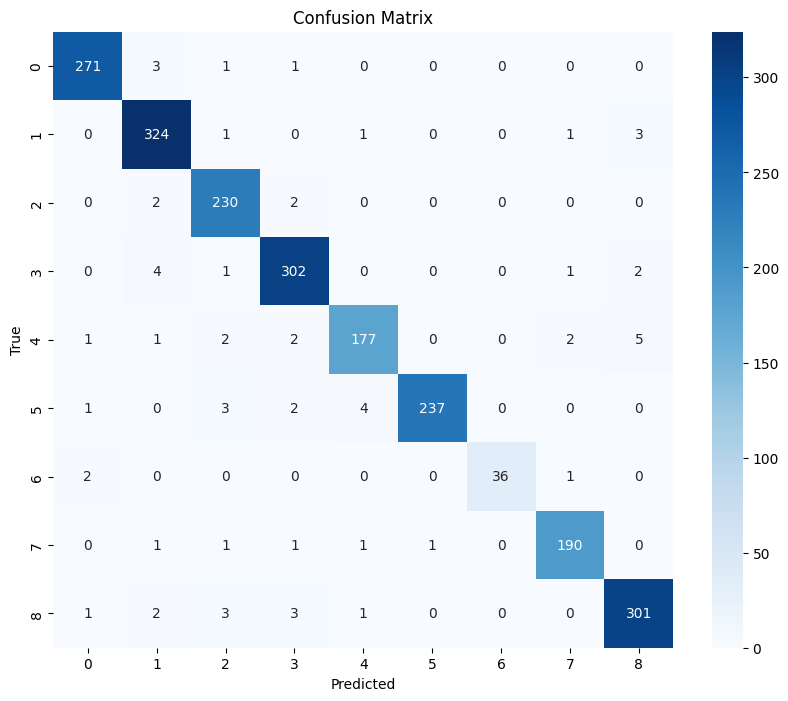

Entrenamiento completado y modelo guardado.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Función para cargar datos
def load_data(output_dir, file_name):
    file_path = os.path.join(output_dir, file_name)
    data = np.load(file_path)
    return data

# Directorio donde se encuentran los datos preprocesados
output_dir = r"C:\Users\Usuario\Desktop\mi_proyecto\imagenes_procesadas"

# Cargar los conjuntos de datos preprocesados
X_train = load_data(output_dir, 'X_train.npy')
y_train = load_data(output_dir, 'y_train.npy')
X_val = load_data(output_dir, 'X_val.npy')
y_val = load_data(output_dir, 'y_val.npy')
X_test = load_data(output_dir, 'X_test.npy')
y_test = load_data(output_dir, 'y_test.npy')

# Verificar dimensiones de datos cargados
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Definir la arquitectura del modelo CNN + LSTM
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Reshape((1, -1)),  # Ajustar la forma para LSTM
    LSTM(64),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Definir los callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Reporte de clasificación
report = classification_report(y_test, y_pred_classes, target_names=np.unique(y_train).astype(str))
print(report)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train).astype(str), yticklabels=np.unique(y_train).astype(str))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Guardar el modelo entrenado
model.save(os.path.join(output_dir, 'modelo_boxeo_cnn_lstm.h5'))

print("Entrenamiento completado y modelo guardado.")

# Graficar las métricas de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.show()
